<a href="https://colab.research.google.com/github/yoyitowang/hotel-revenue-analysis/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [74]:
# loading package
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline
sns.set(font_scale=1.56)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
import scipy.stats as stats
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

In [109]:
# loading data
df_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/敦謙/train.csv", index_col="ID")
df_train.dropna(inplace=True)
df_train.drop(df_train[df_train.Weekend==100].index, inplace=True)
df_train.drop(df_train[df_train.Month==13].index, inplace=True)

df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/敦謙/test.csv", index_col="ID")

df_data = df_train.append(df_test)
df_data.drop(columns="Revenue", inplace=True)
y = df_train["Revenue"]

# for display dataframe
from IPython.display import display
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
# ignore warning
import warnings
warnings.filterwarnings("ignore")

In [106]:
df_train.shape, df_test.shape

((8095, 18), (900, 17))

In [6]:
df_data.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
count,8995.000000,8995.000000,8995.000000,8995.000000,8995.000000,8.995000e+03,8995.000000,8995.000000,8995.000000,8995.000000,8995.000000,8995.000000,8995.000000,8995.000000,8995.000000,8995.000000,8995.000000
mean,2.320289,80.707155,0.502279,32.995828,31.921734,7.495855e+04,0.020401,0.042565,5.872291,0.060723,4.810895,2.239466,7.788327,2.678488,7.663035,1.847471,0.238911
std,3.307800,177.501139,1.265012,134.082479,44.813357,6.034085e+06,0.126088,0.047921,18.181089,0.198458,3.171114,1.657799,3.309325,2.668102,3.922896,0.377062,0.426442
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,1.844667e+02,0.000000,0.014286,0.000000,0.000000,2.000000,1.000000,3.000000,0.000000,4.000000,2.000000,0.000000
50%,1.000000,8.000000,0.000000,0.000000,18.000000,5.995833e+02,0.003125,0.025000,0.000000,0.000000,4.000000,1.000000,10.000000,2.000000,8.000000,2.000000,0.000000
75%,4.000000,92.133333,0.000000,0.000000,38.000000,1.478579e+03,0.016667,0.050000,0.000000,0.000000,8.000000,3.000000,10.000000,6.000000,12.000000,2.000000,0.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,5.634924e+08,0.200000,0.200000,287.953793,1.000000,9.000000,7.000000,12.000000,8.000000,19.000000,2.000000,1.000000


In [4]:
group_weekend = df_train[["Weekend", "Revenue"]].groupby(["Weekend", 'Revenue']).agg({
    "Revenue": lambda x: x.count()
})
group_weekend.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

Revenue
Weekend Revenue           
0       0        84.700521
        1        15.299479
1       0        82.726807
        1        17.273193

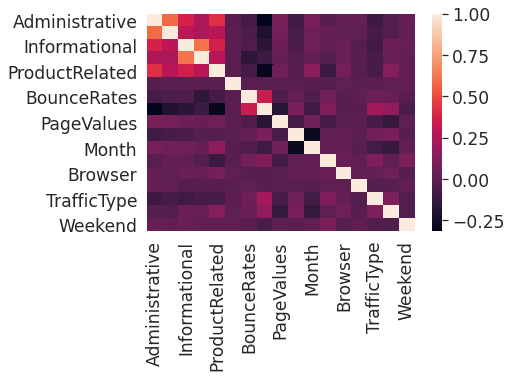

In [5]:
sns.heatmap(df_data.corr())

Administrative


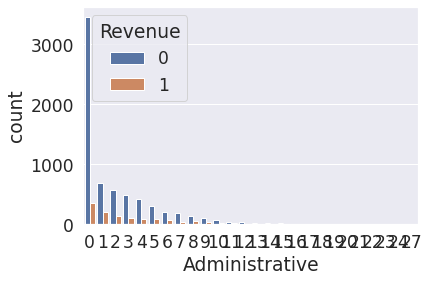

Administrative_Duration
Informational


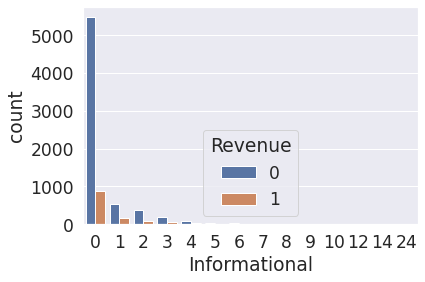

Informational_Duration
ProductRelated
ProductRelated_Duration
BounceRates
ExitRates
PageValues
SpecialDay


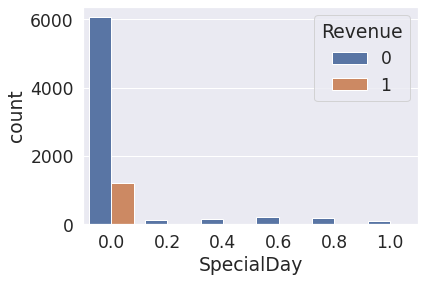

Month


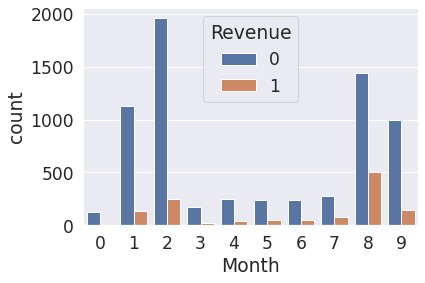

OperatingSystems


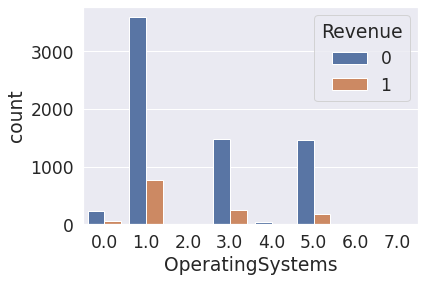

Browser


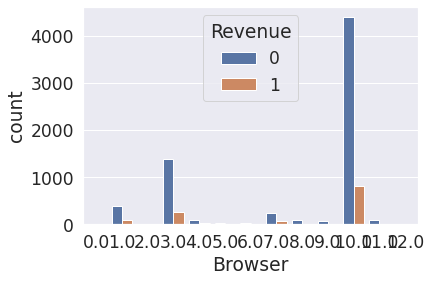

Region


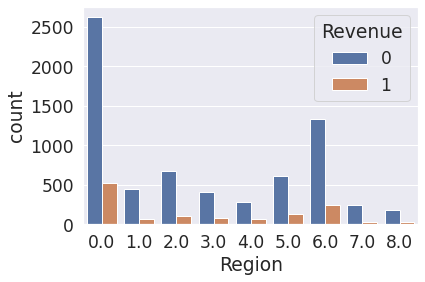

TrafficType


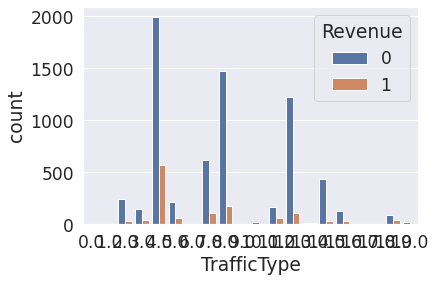

VisitorType


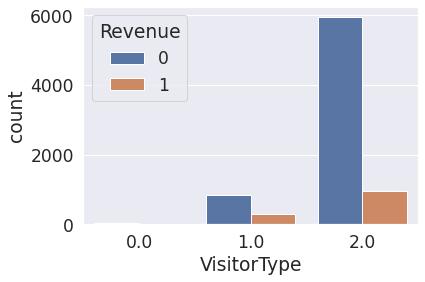

Weekend


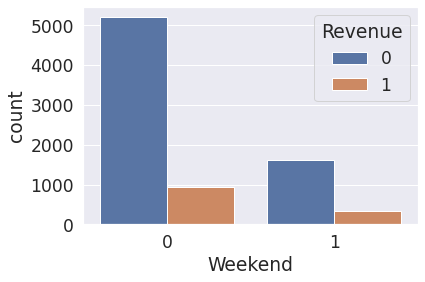

Revenue


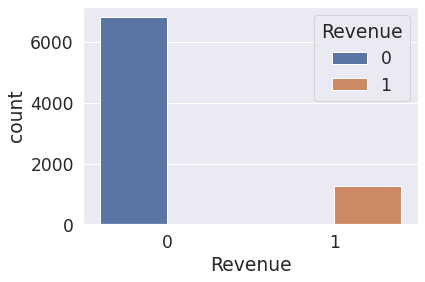

In [7]:
for col in df_train.columns:
  print(col)
  if df_train[col].nunique() < 50:
    sns.countplot(df_train[col], hue=df_train["Revenue"])
    plt.show()

In [9]:
# mean_list = ["Administrative_mean", "Informational_mean", "ProductRelated_mean"]
# for col in mean_list:
#   print(col)
#   g = sns.FacetGrid(df_data, y)
#   g.map(sns.displot, col, kde=True)
#   plt.show()

In [112]:
df_data["Administrative_mean"] = np.log1p(df_data.Administrative_Duration/df_data.Administrative).replace(np.inf, 0).replace(np.nan, 0)
df_data["Informational_mean"] = np.log1p(df_data.Informational/df_data.Informational_Duration).replace(np.inf, 0).replace(np.nan, 0)
df_data["ProductRelated_mean"] = np.log1p(df_data.ProductRelated/df_data.ProductRelated_Duration).replace(np.inf, 0).replace(np.nan, 0)

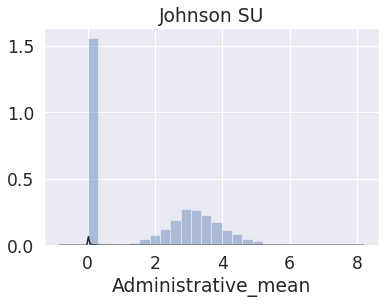

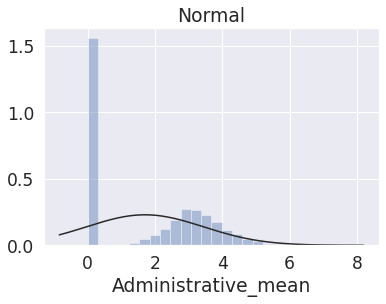

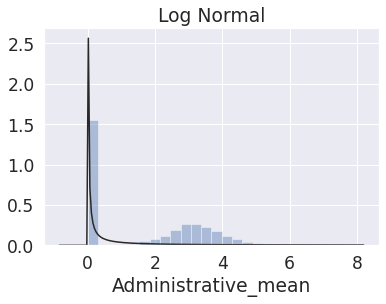

In [13]:
plt.figure(1); plt.title('Johnson SU')
sns.distplot(df_data["Administrative_mean"], kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(df_data["Administrative_mean"], kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(df_data["Administrative_mean"], kde=False, fit=stats.lognorm)

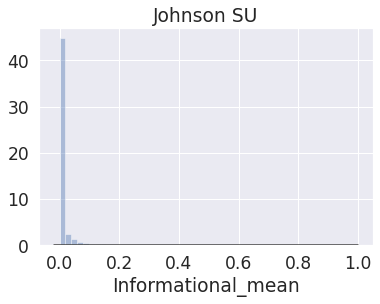

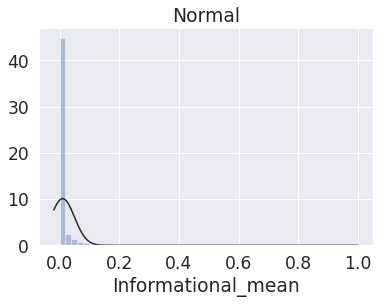

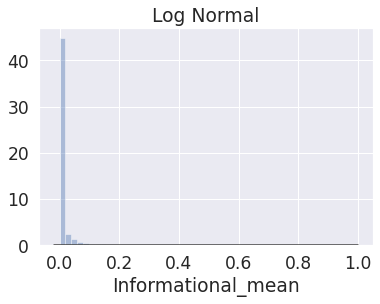

In [14]:
plt.figure(1); plt.title('Johnson SU')
sns.distplotdf_data["Informational_mean"]y, kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(df_data["Informational_mean"], kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(df_data["Informational_mean"], kde=False, fit=stats.lognorm)

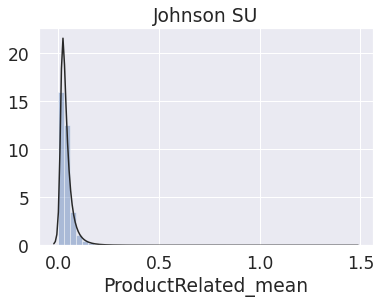

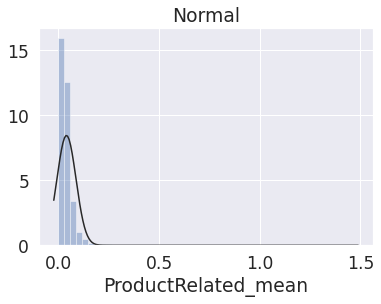

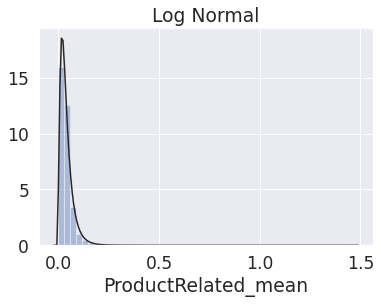

In [15]:
plt.figure(1); plt.title('Johnson SU')
sns.distplot(df_data["ProductRelated_mean"], kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(df_data["ProductRelated_mean"], kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(df_data["ProductRelated_mean"], kde=False, fit=stats.lognorm)

In [19]:
for col in df_data.columns:
  print(f"{col} has nunique: {df_data[col].nunique()}")

Administrative has nunique: 26
Administrative_Duration has nunique: 2590
Informational has nunique: 15
Informational_Duration has nunique: 971
ProductRelated has nunique: 281
ProductRelated_Duration has nunique: 7193
BounceRates has nunique: 1494
ExitRates has nunique: 3577
PageValues has nunique: 1993
SpecialDay has nunique: 6
Month has nunique: 10
OperatingSystems has nunique: 8
Browser has nunique: 13
Region has nunique: 9
TrafficType has nunique: 20
VisitorType has nunique: 3
Weekend has nunique: 2
Administrative_mean has nunique: 2959
Informational_mean has nunique: 1058
ProductRelated_mean has nunique: 7690


In [113]:
quantitative = df_data.columns[:10].append(df_data.columns[17:])
qualitative = df_data.columns[10:17]
quantitative, qualitative

(Index(['Administrative', 'Administrative_Duration', 'Informational',
        'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
        'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay',
        'Administrative_mean', 'Informational_mean', 'ProductRelated_mean'],
       dtype='object'),
 Index(['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType',
        'VisitorType', 'Weekend'],
       dtype='object'))

In [114]:
df_data[qualitative] = df_data[qualitative].astype("O")
df_data.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems            object
Browser                     object
Region                      object
TrafficType                 object
VisitorType                 object
Weekend                     object
Administrative_mean        float64
Informational_mean         float64
ProductRelated_mean        float64
dtype: object

0.8217643978203762


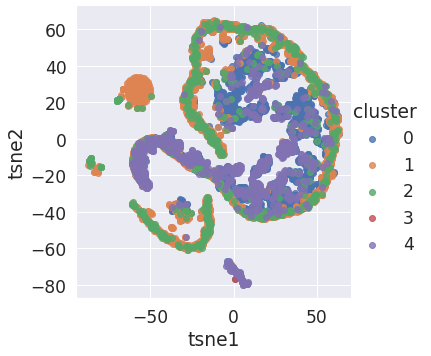

In [30]:
model = TSNE(n_components=2, random_state=0, perplexity=50)
X = df_data[quantitative].fillna(0.).values
tsne = model.fit_transform(X)

std = StandardScaler()
s = std.fit_transform(X)
pca = PCA(n_components=0.8)
pca.fit(s)
pc = pca.transform(s)
kmeans = KMeans(n_clusters=5)
kmeans.fit(pc)

fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
print(np.sum(pca.explained_variance_ratio_))

In [115]:
df_data[quantitative] = s
X = pd.get_dummies(df_data).reset_index(drop=True)
X_sub_train = X[:len(df_train)]
X_sub = X[len(df_train):]

# df_train = pc[:len(df_train)]
# df_test = pc[len(df_train):]

X_train, X_test, y_train, y_test = train_test_split(X_sub_train, y, test_size=0.2, random_state=42)

In [63]:
xgb = XGBClassifier(learning_rate=0.01, 
                    n_estimators=3460, 
                    max_depth=3, 
                    min_child_weight=0, 
                    gamma=0, 
                    subsample=0.7, 
                    colsample_bytree=0.7, 
                    objective='binary:logistic', 
                    nthread=-1, 
                    scale_pos_weight=y.value_counts()[0]/y.value_counts()[1], 
                    seed=1,
                    reg_alpha=0.00006)

# xgb.fit(X_train, y_train)

pipeline = Pipeline([
    # ('standard_scaler', StandardScaler()),
    ('pca', PCA(10)),
    ('model', xgb)
])

param_grid = {
    # 'pca__n_components': [4,6,8,10],
    'model__min_child_weight': [0.01],
    # 'model__base_score': [0.4, 0.5, 0.6],
}

grid_xgb = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
grid_xgb.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=10, random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('model',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=0.7,
                                                      gamma=0,
                                                      learning_rate=0.01,
                             

In [70]:
print('参数的最佳取值:{0}'.format(grid_xgb.best_params_))
print('最佳模型得分:{0}'.format(grid_xgb.best_score_))
print(grid_xgb.cv_results_['mean_test_score'])
print(grid_xgb.cv_results_['params'])

参数的最佳取值:{'model__min_child_weight': 0.01}
最佳模型得分:0.8931330598904739
[0.89313306]
[{'model__min_child_weight': 0.01}]


Confusion matrix, without normalization
[[1239  124]
 [  67  189]]
Normalized confusion matrix
[[0.90902421 0.09097579]
 [0.26171875 0.73828125]]


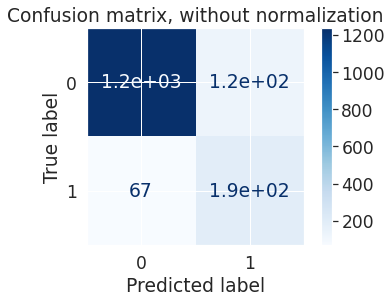

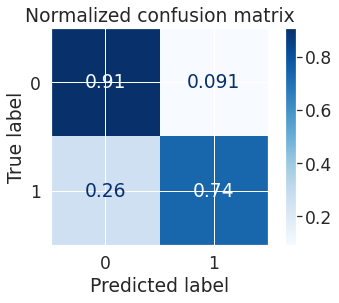

In [65]:
from sklearn.metrics import plot_confusion_matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(grid_xgb, X_test, y_test, display_labels=[0, 1], cmap=plt.cm.Blues, normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [66]:
gbm = LGBMClassifier(objective = 'binary',
                         is_unbalance = True,
                         metric = 'auc',
                         max_depth = 6,
                         num_leaves = 10,
                         learning_rate = 0.01,
                         feature_fraction = 0.5,
                         min_child_samples=25,
                         min_child_weight=0.001,
                         bagging_fraction = 0.7,
                         bagging_freq = 2,
                         reg_alpha = 0.001,
                         reg_lambda = 8,
                         cat_smooth = 0,
                         num_iterations = 300,   
                        )


pipeline = Pipeline([
    # ('standard_scaler', StandardScaler()),
    # ('pca', PCA()),
    ('model', gbm)
])

param_grid = {
    # 'pca__n_components': [4,6,8],
    'model__learning_rate': [0.01],
    # 'model__max_depth': [4,6,8,10],
    # 'model__num_leaves': [3,5,7,9,11],
    # 'model__min_child_samples': [15, 20, 25],
    # 'model__min_child_weight': [0.001, 0.002, 0.005],
    # 'model__feature_fraction': [0.6, 0.8, 1],
    # 'model__bagging_fraction': [0.8, 0.9, 1],
    # 'model__bagging_freq': [2, 3],
    # 'model__cat_smooth': [0, 10, 20],

}

grid_gbm = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='roc_auc')

In [67]:
%%time
grid_gbm.fit(X_train, y_train)

CPU times: user 574 ms, sys: 19.8 ms, total: 593 ms
Wall time: 2.56 s


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('model',
                                        LGBMClassifier(bagging_fraction=0.7,
                                                       bagging_freq=2,
                                                       boosting_type='gbdt',
                                                       cat_smooth=0,
                                                       class_weight=None,
                                                       colsample_bytree=1.0,
                                                       feature_fraction=0.5,
                                                       importance_type='split',
                                                       is_unbalance=True,
                                                       learning_rate=0.01,
                                                       max_depth=6,
                                                   

In [68]:
print('参数的最佳取值:{0}'.format(grid.best_params_))
print('最佳模型得分:{0}'.format(grid.best_score_))
print(grid.cv_results_['mean_test_score'])
print(grid.cv_results_['params'])

参数的最佳取值:{'model__learning_rate': 0.01}
最佳模型得分:0.9281070459974023
[0.92810705]
[{'model__learning_rate': 0.01}]


Confusion matrix, without normalization
[[1177  186]
 [  41  215]]
Normalized confusion matrix
[[0.86353632 0.13646368]
 [0.16015625 0.83984375]]


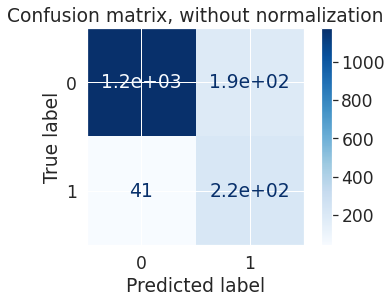

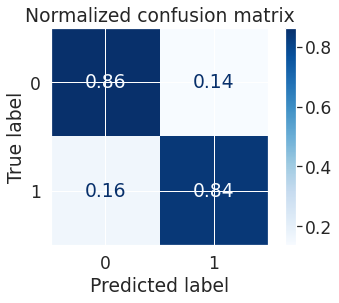

In [69]:
for title, normalize in titles_options:
    disp = plot_confusion_matrix(grid, X_test, y_test, display_labels=[0, 1], cmap=plt.cm.Blues, normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [76]:
estimators = [('xgb', grid_xgb), ('lgbm', grid_gbm)]
stack_gen = StackingClassifier(estimators=estimators, cv=5, final_estimator=LogisticRegression())
stack_gen.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('xgb',
                                GridSearchCV(cv=5, error_score=nan,
                                             estimator=Pipeline(memory=None,
                                                                steps=[('pca',
                                                                        PCA(copy=True,
                                                                            iterated_power='auto',
                                                                            n_components=10,
                                                                            random_state=None,
                                                                            svd_solver='auto',
                                                                            tol=0.0,
                                                                            whiten=False)),
                                                                  

In [77]:
print('最佳模型得分:{0}'.format(stack_gen.score(X_test, y_test)))

最佳模型得分:0.8925262507720816


Confusion matrix, without normalization
[[1276   87]
 [  87  169]]
Normalized confusion matrix
[[0.93617021 0.06382979]
 [0.33984375 0.66015625]]


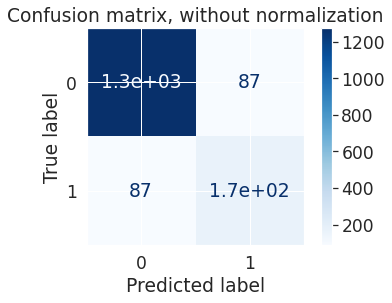

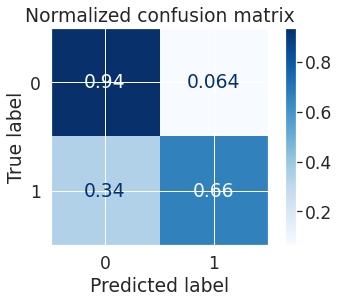

In [78]:
for title, normalize in titles_options:
    disp = plot_confusion_matrix(stack_gen, X_test, y_test, display_labels=[0, 1], cmap=plt.cm.Blues, normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [127]:
pred = pd.DataFrame(stack_gen.predict_proba(X_sub))
submission =pd.DataFrame({'ID': df_test.index.values, 'HasRevenue': pred[1]})
submission.to_csv("/content/drive/MyDrive/Colab Notebooks/敦謙/submission.csv")